In [1]:
import numpy as np
import gensim, logging
import csv, string
import nltk
#nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import pandas as pd
import tensorflow as tf
import os
import pickle

num_words = 200
num_words_description = 200
directory_prefix = "../"
label_depth = 3
import random
#import gensim.downloader as api
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords


import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1")
#embed = hub.load("https://tfhub.dev/google/Wiki-words-500/2")

embeddings = embed(["cat is on the mat", "dog is in the fog"])
embedding_dim = embeddings.shape[1]
#print(embeddings)
def get_sentence_vector(words, num_words):
    words = word_tokenize(remove_stopwords(words))
    #words = list(filter(lambda w: len(w)>2, words))
    ret = embed(words)
    ret = tf.pad(ret, tf.constant([[0, max(0, num_words-ret.shape[0]),], [0, 0]]), "CONSTANT")
    ret = ret[:num_words]
    return ret
 
with open(directory_prefix+"/class_descriptions/class_descriptions_from_patents.pickle", 'rb') as f:
    label_dict = pickle.load(f)
label_dict = {k[:label_depth]: get_sentence_vector(val.lower(), num_words_description) for k, val in label_dict.items()}
#label_dict = {k[:label_depth]: get_sentence_vector(val.lower(), num_words_description) for k, val in label_dict.items()}

label_dict_keys = set(label_dict.keys())


[nltk_data] Downloading package stopwords to /home/jpark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
print(embedding_dim)

128


In [33]:
number_occurences=400
def lstm_data_generator():
    occurences = {k:0 for k in label_dict.keys()}
    current_dataframe = pd.read_csv(directory_prefix+'/datasets/items2.csv',sep=',', header = None).to_numpy()#, chunksize=100000)
    indices = np.random.choice(len(current_dataframe), len(current_dataframe)//2)
    for row in current_dataframe[indices]:
        label, description=row[0], row[1]
        lstm_input_patent = get_sentence_vector(description.lower(), num_words)
        label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
        label_vectors = set([i for i in label_vectors if i in label_dict_keys])
        non_true_vectors = set([i for i in random.sample(label_dict_keys, min(len(label_vectors), len(label_dict.keys()))) if i not in label_vectors])
        for l, k in zip((label_dict[i] for i in label_vectors), label_vectors):
            if occurences[k] >= number_occurences:
                continue
            occurences[k] +=1
            yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[1]})
        for l, k in zip((label_dict[i] for i in non_true_vectors), non_true_vectors):
            if occurences[k] >= number_occurences:
                continue
            occurences[k] +=1
            yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[0]})
        if sum(occurences.values()) >= len(label_dict)*(number_occurences-4):
            print("done with occurences\n\n")
            return

lstm_dataset = tf.data.Dataset.from_generator(lstm_data_generator, ({'input_1':tf.float64, 'input_2':tf.float64}, {'output_binary':tf.float64}), ({'input_1':tf.TensorShape([num_words, embedding_dim]), 'input_2':tf.TensorShape([num_words_description, embedding_dim])}, {'output_binary':tf.TensorShape([1])}))
lstm_dataset = lstm_dataset.batch(16, drop_remainder=True).prefetch(100).repeat()
           

In [12]:


input_lstm = tf.keras.Input(shape=(num_words, embedding_dim), name='input_1')
input_label = tf.keras.Input(shape=(num_words_description, embedding_dim), name='input_2')

patent_mask = tf.keras.layers.Masking(mask_value=0., input_shape=(num_words, embedding_dim))(input_lstm)
label_mask = tf.keras.layers.Masking(mask_value=0., input_shape=(num_words_description, embedding_dim))(input_label)

layer_size = embedding_dim*2
patent = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True))(patent_mask)
label = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True))(label_mask)

#


patent = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(layer_size//2))(patent)
patent = tf.keras.layers.GlobalAveragePooling1D()(patent)

label = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(layer_size//2))(label)
label = tf.keras.layers.GlobalAveragePooling1D()(label)
#patent = tf.keras.layers.Dense(layer_size//2)(patent)
#label =  tf.keras.layers.Dense(layer_size//2)(label)

#subtract = tf.keras.layers.Subtract()([patent, label])
#multiply = tf.keras.layers.Multiply()([patent, label])

concat = tf.keras.layers.Concatenate(axis=1)([label, patent])
dense = tf.keras.layers.Dense(int(layer_size))(concat)
dense = tf.keras.layers.Dense(int(layer_size))(dense)
dense = tf.keras.layers.Dense(int(layer_size), activation='relu')(dense)
dense = tf.keras.layers.Dense(int(layer_size), activation='relu')(dense)
dense = tf.keras.layers.Dense(int(layer_size), activation='relu')(dense)

output_binary = tf.keras.layers.Dense(1, name='output_binary')(dense)


#lstm_enforce_1 = tf.keras.layers.Dense(200, activation='relu')(patent_lstm)
#lstm_enforce_2 = tf.keras.layers.Dense(1000, name='output_2')(lstm_enforce_1)
#model = tf.keras.Model(inputs={'input_1':input_lstm, 'input_2':input_label}, outputs={'output_1':output_binary, 'output_2':lstm_enforce_2})
model = tf.keras.Model(inputs={'input_1':input_lstm, 'input_2':input_label}, outputs=[output_binary])
print(model)

In [13]:
print(len(label_dict))

128


In [18]:
#saver = tf.train.Saver(max_to_keep=4, keep_checkpoint_every_n_hours=2)
#del model
try:
    model.load_weights(directory_prefix+"checkpoints/LSTMWithoutAttention-V1NewDataset.h5")
except:
    pass

model.summary()
opt = tf.optimizers.Adam(1e-5)
model.compile(loss=['binary_crossentropy'],
              optimizer=opt,
              metrics=['accuracy'], experimental_run_tf_function=False)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=directory_prefix+"checkpoints/LSTMWithoutAttention-V1NewDataset.h5",
                                                 save_weights_only=False,
                                                 verbose=1)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        generate_prc()
prc_callback = CustomCallback()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 128)]   0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 200, 128)]   0                                            
__________________________________________________________________________________________________
masking_3 (Masking)             (None, 200, 128)     0           input_2[0][0]                    
__________________________________________________________________________________________________
masking_2 (Masking)             (None, 200, 128)     0           input_1[0][0]                    
_______________________________________________________________________________________

{'B01': 120, 'G09': 81, 'G11': 189, 'G03': 126, 'E04': 53, 'C07': 108, 'F28': 27, 'D05': 4, 'G04': 4, 'Y04': 3, 'C23': 49, 'F01': 65, 'B66': 17, 'A23': 39, 'C21': 13, 'Y02': 315, 'B41': 39, 'F25': 33, 'G02': 181, 'C05': 4, 'H03': 101, 'A21': 2, 'F22': 3, 'B27': 9, 'F04': 33, 'B26': 8, 'A01': 83, 'C12': 128, 'C02': 22, 'F23': 18, 'C08': 72, 'B62': 27, 'B64': 39, 'A47': 58, 'B67': 6, 'B33': 7, 'B25': 29, 'G12': 0, 'B29': 73, 'G21': 15, 'G06': 190, 'H05': 87, 'B24': 4, 'H01': 570, 'A24': 1, 'B68': 2, 'F41': 24, 'B30': 6, 'C11': 19, 'E01': 12, 'C14': 1, 'B05': 19, 'F17': 7, 'G08': 19, 'E02': 13, 'B81': 11, 'B42': 9, 'B06': 3, 'F03': 18, 'E06': 9, 'C40': 1, 'B08': 9, 'G01': 295, 'A61': 319, 'C06': 2, 'F02': 59, 'F15': 4, 'B23': 53, 'B63': 11, 'B28': 6, 'B07': 6, 'A62': 7, 'B31': 1, 'H02': 121, 'C25': 8, 'B03': 11, 'F26': 5, 'C10': 20, 'B61': 2, 'C03': 22, 'F27': 3, 'G05': 13, 'Y10': 455, 'F24': 36, 'E05': 15, 'B60': 107, 'A45': 21, 'E03': 9, 'D03': 3, 'B32': 36, 'G16': 11, 'B21': 17, 'F42':

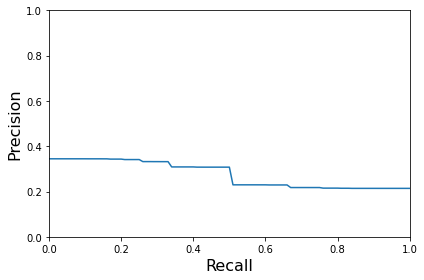

<Figure size 432x288 with 0 Axes>

In [24]:
current_dataframe = pd.read_csv(directory_prefix+'/datasets/items1.csv',sep=',', header = None).to_numpy()#, chunksize=100000)
#indices = np.random.choice(300000, 10000)
occurences={k:0 for k in label_dict_keys}
for row in current_dataframe:
    label, description=row[0], row[1]
    lstm_input_patent = get_sentence_vector(description.lower(), num_words)
    label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
    label_vectors = set([i for i in label_vectors if i in label_dict_keys])
    for i in label_vectors:
        occurences[i] += 1
print(occurences)
n = 0
d=0
recalls = np.arange(0, 1.01, .01)
ns = []
prediction = sorted(occurences.keys(), key=lambda x: occurences[x])[::-1]
print(prediction)
for row in pd.read_csv(directory_prefix+'datasets/items1.csv',sep=',', header = None).to_numpy():
    label, description=row[0], row[1]
    label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
    label_vectors = set([i for i in label_vectors if i in label_dict_keys])
    if label_vectors == set():
        continue
    #indices = np.flip(np.argsort(prediction, axis=0))
    
    #print(indices)
    e = [1 if i in label_vectors else 0 for i in prediction]
    cur = []
    total_ones = e.count(1)
    n = 0
    ones_seen = 0
    while ones_seen < total_ones:
        if e[n] == 1:
            ones_seen = ones_seen+1
        n = n+1
        cur.append((ones_seen/float(n), ones_seen/float(total_ones)))
    new_cur = []
    for r in recalls:
        max_of_larger = max([i[0] for i in cur if i[1] >= r])
        new_cur.append(max_of_larger)
    ns.append(new_cur)
    #print(max(new_cur))
    d = d+1
    #print(float(d)/7215)
    #print(np.mean(np.vstack(ns), axis=0)[0])
p_baseline = np.mean(np.array(ns), axis=0)
import matplotlib.pyplot as plt
plt.plot(recalls, p_baseline)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.margins(0.1)
#plt.xticks(range(len(distribution_dict.keys()))[::50], new_x[::50], rotation='vertical')
plt.ylabel('Precision', fontsize=16)
plt.xlabel('Recall', fontsize=16)
plt.tight_layout()
plt.show()
#print(p) 
plt.savefig('binary_prc1.eps', format='eps')

3000/3000 [==============================] - 141s 47ms/step


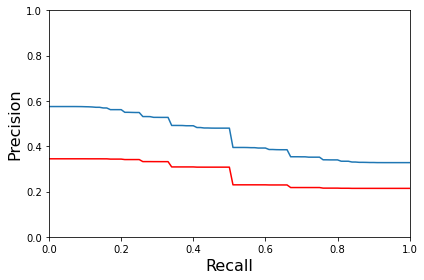

<Figure size 432x288 with 0 Axes>

In [35]:
def generate_prc():
    label_len = len(label_dict_keys)
    #print(label_len)
    left = [label_dict[i] for i in label_dict_keys]
    predictions = []
    left_vectors = np.array(list(label_dict_keys))
    label_vectors_vector = []
    num_tests = 3000
    def cur_gen():
        for row in pd.read_csv(directory_prefix+'datasets/test_dataset.csv',sep=',', header = None).to_numpy():
            label, description=row[0], row[1]
            label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
            label_vectors = set([i for i in label_vectors if i in label_dict_keys])
            if label_vectors == set():
                continue
            label_vectors_vector.append(label_vectors)
            lstm_input_patent =  get_sentence_vector(description.lower(), num_words)
            for i in left:
                yield ({'input_1':lstm_input_patent, 'input_2':i})

    dataset = tf.data.Dataset.from_generator(cur_gen, ({'input_1':tf.float64, 'input_2':tf.float64}), ({'input_1':tf.TensorShape([num_words, embedding_dim]), 'input_2':tf.TensorShape([num_words_description, embedding_dim])}))
    dataset = dataset.batch(label_len).prefetch(50)
    predictions = model.predict(dataset, steps=num_tests, verbose=1).reshape(num_tests, label_len)
    n = 0
    d=0
    recalls = np.arange(0, 1.01, .01)
    ns = []
    
    for prediction, label_vectors in zip(predictions, label_vectors_vector):
        indices = np.flip(np.argsort(prediction, axis=0))
        #print(indices)
        e = [1 if i in label_vectors else 0 for i in left_vectors[indices]]
        cur = []
        total_ones = e.count(1)
        n = 0
        ones_seen = 0
        while ones_seen < total_ones:
            if e[n] == 1:
                ones_seen = ones_seen+1
            n = n+1
            cur.append((ones_seen/float(n), ones_seen/float(total_ones)))
        new_cur = []
        for r in recalls:
            max_of_larger = max([i[0] for i in cur if i[1] >= r])
            new_cur.append(max_of_larger)
        ns.append(new_cur)
        #print(max(new_cur))
        d = d+1
        #print(float(d)/7215)
        #print(np.mean(np.vstack(ns), axis=0)[0])
    p = np.mean(np.array(ns), axis=0)
    import matplotlib.pyplot as plt
    plt.plot(recalls, p)
    plt.plot(recalls, p_baseline, 'r')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.margins(0.1)
    #plt.xticks(range(len(distribution_dict.keys()))[::50], new_x[::50], rotation='vertical')
    plt.ylabel('Precision', fontsize=16)
    plt.xlabel('Recall', fontsize=16)
    plt.tight_layout()
    plt.show()
    #print(p) 
    plt.savefig('binary_prc1.eps', format='eps')
generate_prc()

In [ ]:
history = model.fit(lstm_dataset, epochs=50, steps_per_epoch=3000, callbacks=[cp_callback, prc_callback])

1000/1000 [==============================] - 34s 34ms/step


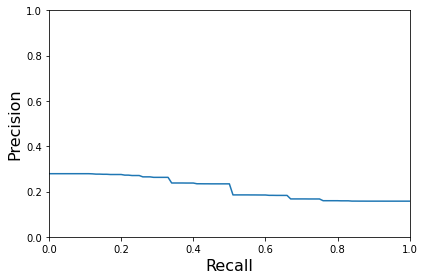

<Figure size 432x288 with 0 Axes>

In [12]:

generate_prc()